# Predicting Weeks on the Chart

This notebook will focus on trying to use Spotify's audio features to predict an album's staying power in the charts.

---

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Basics
import pandas as pd
import numpy as np
import re

#Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Feature work
from sklearn.feature_extraction.text import CountVectorizer

# PreProcessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split

# Modelling
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import LinearSVC
from imblearn.pipeline import make_pipeline, Pipeline

#Scoring
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report

# Imports and EDA

Lets bring in the data and merge our sets. We will lose some data, but given the sample size, it won't be critical.

In [6]:
filepath = 'data/'
charts = pd.read_csv(filepath+'new/hot_stuff_2.csv')

In [4]:
charts.head()

url      weekid  \
0  http://www.billboard.com/charts/hot-100/1958-0...  1958-08-02   
1  http://www.billboard.com/charts/hot-100/1995-1...  1995-12-02   
2  http://www.billboard.com/charts/hot-100/1997-1...  1997-10-11   
3  http://www.billboard.com/charts/hot-100/2006-0...  2006-07-01   
4  http://www.billboard.com/charts/hot-100/2009-1...  2009-10-24   

   week_position                                               song  \
0              1                                   Poor Little Fool   
1              1                                      One Sweet Day   
2              1  Candle In The Wind 1997/Something About The Wa...   
3              1                                Do I Make You Proud   
4              1                                                  3   

                    performer  \
0                Ricky Nelson   
1  Mariah Carey & Boyz II Men   
2                  Elton John   
3                Taylor Hicks   
4              Britney Spears   

                                              songid  instance  \
0                       Poor Little FoolRicky Nelson         1   
1            One Sweet DayMariah Carey & Boyz II Men         1   
2  Candle In The Wind 1997/Something About The Wa...         1   
3                    Do I Make You ProudTaylor Hicks         1   
4                                    3Britney Spears         1   

   previous_week_position  peak_position  weeks_on_chart  
0                     NaN              1               1  
1                     NaN              1               1  
2                     NaN              1               1  
3                     NaN              1               1  
4                     NaN              1               1

In [5]:
charts.shape

(320495, 10)

In [7]:
filepath = 'data/'
audio = pd.read_csv(filepath+'new/audiio.csv')

In [7]:
audio.head()

songid  \
0                      AdictoTainy, Anuel AA & Ozuna   
1  The Ones That Didn't Make It Back HomeJustin M...   
2                  ShallowLady Gaga & Bradley Cooper   
3                EnemiesPost Malone Featuring DaBaby   
4    Bacc At It AgainYella Beezy, Gucci Mane & Quavo   

                         performer                                    song  \
0          Tainy, Anuel AA & Ozuna                                  Adicto   
1                     Justin Moore  The Ones That Didn't Make It Back Home   
2       Lady Gaga & Bradley Cooper                                 Shallow   
3     Post Malone Featuring DaBaby                                 Enemies   
4  Yella Beezy, Gucci Mane & Quavo                        Bacc At It Again   

                                       spotify_genre        spotify_track_id  \
0                                  ['pop reggaeton']  3jbT1Y5MoPwEIpZndDDwVq   
1  ['arkansas country', 'contemporary country', '...                     NaN   
2                               ['dance pop', 'pop']  2VxeLyX666F8uXCJ0dZF8B   
3                  ['dfw rap', 'melodic rap', 'rap']  0Xek5rqai2jcOWCYWJfVCF   
4     ['dfw rap', 'rap', 'southern hip hop', 'trap']  2biNa12dMbHJrHVFRt8JyO   

                           spotify_track_preview_url  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  https://p.scdn.co/mp3-preview/fa6fa6f6f363be29...   

              spotify_track_album spotify_track_explicit  \
0  Adicto (with Anuel AA & Ozuna)                  False   
1                             NaN                    NaN   
2       A Star Is Born Soundtrack                  False   
3            Hollywood's Bleeding                   True   
4                Bacc At It Again                   True   

   spotify_track_duration_ms  spotify_track_popularity  ...   key  loudness  \
0                   270740.0                      91.0  ...  10.0    -4.803   
1                        NaN                       NaN  ...   NaN       NaN   
2                   215733.0                      88.0  ...   7.0    -6.362   
3                   196760.0                      86.0  ...   6.0    -4.169   
4                   228185.0                      61.0  ...   8.0    -5.725   

    mode  speechiness acousticness  instrumentalness  liveness  valence  \
0  False       0.0735      0.01700          0.000016    0.1790    0.623   
1    NaN          NaN          NaN               NaN       NaN      NaN   
2   True       0.0308      0.37100          0.000000    0.2310    0.323   
3   True       0.2100      0.05880          0.000000    0.0955    0.667   
4  False       0.1680      0.00124          0.000001    0.0716    0.856   

     tempo  time_signature  
0   80.002             4.0  
1      NaN             NaN  
2   95.799             4.0  
3   76.388             4.0  
4  135.979             4.0  

[5 rows x 22 columns]

In [8]:
df = pd.merge(charts, audio,
             on='songid',
             how='left',
             suffixes=('', '_y'))

In [9]:
cols_to_drop = [col for col in list(df.columns) if '_y' in col]+['spotify_track_preview_url', 
                                                                 'url', 'spotify_track_id',
                                                                 'spotify_track_album', 'spotify_track_explicit']
df.drop(cols_to_drop, axis = 1, inplace = True)

In [10]:
df.isnull().sum()

weekid                           0
week_position                    0
song                             0
performer                        0
songid                           0
instance                         0
previous_week_position       30991
peak_position                    0
weeks_on_chart                   0
spotify_genre                13324
spotify_track_duration_ms    42191
spotify_track_popularity     42191
danceability                 42749
energy                       42749
key                          42749
loudness                     42749
mode                         42749
speechiness                  42749
acousticness                 42749
instrumentalness             42749
liveness                     42749
valence                      42749
tempo                        42749
time_signature               42749
dtype: int64

In [11]:
print('If we drop these rows, we will lose {}% of our data.'.format(round(df.isnull().sum().max()/df.shape[0]*100,2)))

If we drop these rows, we will lose 13.24% of our data.


In [10]:
df.dropna(inplace = True)

In [9]:
(df[df['weeks_on_chart']>60][['songid','weeks_on_chart']])\
             .drop_duplicates(subset='songid', keep='last')\
             .sort_values('weeks_on_chart')



songid  weeks_on_chart
21544                               DemonsImagine Dragons              61
138190                                You And MeLifehouse              62
315935                                Ho HeyThe Lumineers              62
79257                    Before He CheatsCarrie Underwood              64
20523                            Rolling In The DeepAdele              65
20532   Party Rock AnthemLMFAO Featuring Lauren Bennet...              68
79261                           Counting StarsOneRepublic              68
315952                           How Do I LiveLeAnn Rimes              69
315959                                I'm YoursJason Mraz              76
20554                                      SailAWOLNATION              79
20562                          RadioactiveImagine Dragons              87

# Engineering some new Features

### Genre

In [11]:
def merge_words(gen_list):
    gen_list_new = []
    for i in gen_list:
        gen_list_new.append(i.replace(' ',''))
    return gen_list_new

In [12]:
df['spotify_genre'] = df['spotify_genre'].apply(lambda x: re.sub(r'[\[\]]','',x))\
                                         .apply(lambda x: x.split(','))\
                                         .apply(lambda x: merge_words(x))\
                                         .apply(lambda x: ' '.join(x))
                                            

In [13]:
vectoriser = CountVectorizer()
sparse_genres = vectoriser.fit_transform(df['spotify_genre'])

genres_df = pd.DataFrame(sparse_genres.todense(), columns=vectoriser.get_feature_names())

In [14]:
drop_genre_cols = (genres_df.sum()>15000)
drop_genre_cols = [x for x, y in zip(list(drop_genre_cols.index), list(drop_genre_cols.values)) if y == False]

In [15]:
genres_df.drop(drop_genre_cols, axis=1, inplace=True)

In [16]:
genres_df['other'] = genres_df.apply(lambda x: 1 if x.sum()==0 else 0, axis = 1)

In [17]:
df = pd.concat([df.drop('spotify_genre', axis = 1).reset_index(drop = True), genres_df], axis = 1)

In [18]:
genres_df.sum().sort_values().tail(10)

albumrock         25644
poprap            28717
adultstandards    28900
post              29788
pop               39831
softrock          40400
mellowgold        40787
dancepop          41565
other             44045
rock              47276
dtype: int64

# Predicting Song Positions

When not considering time as a variable, predicting how well a song will do in the charts is difficult.

In [19]:
peak_df = df.sort_values(by='weeks_on_chart',ascending=True).drop_duplicates(subset ='songid', keep ='last')

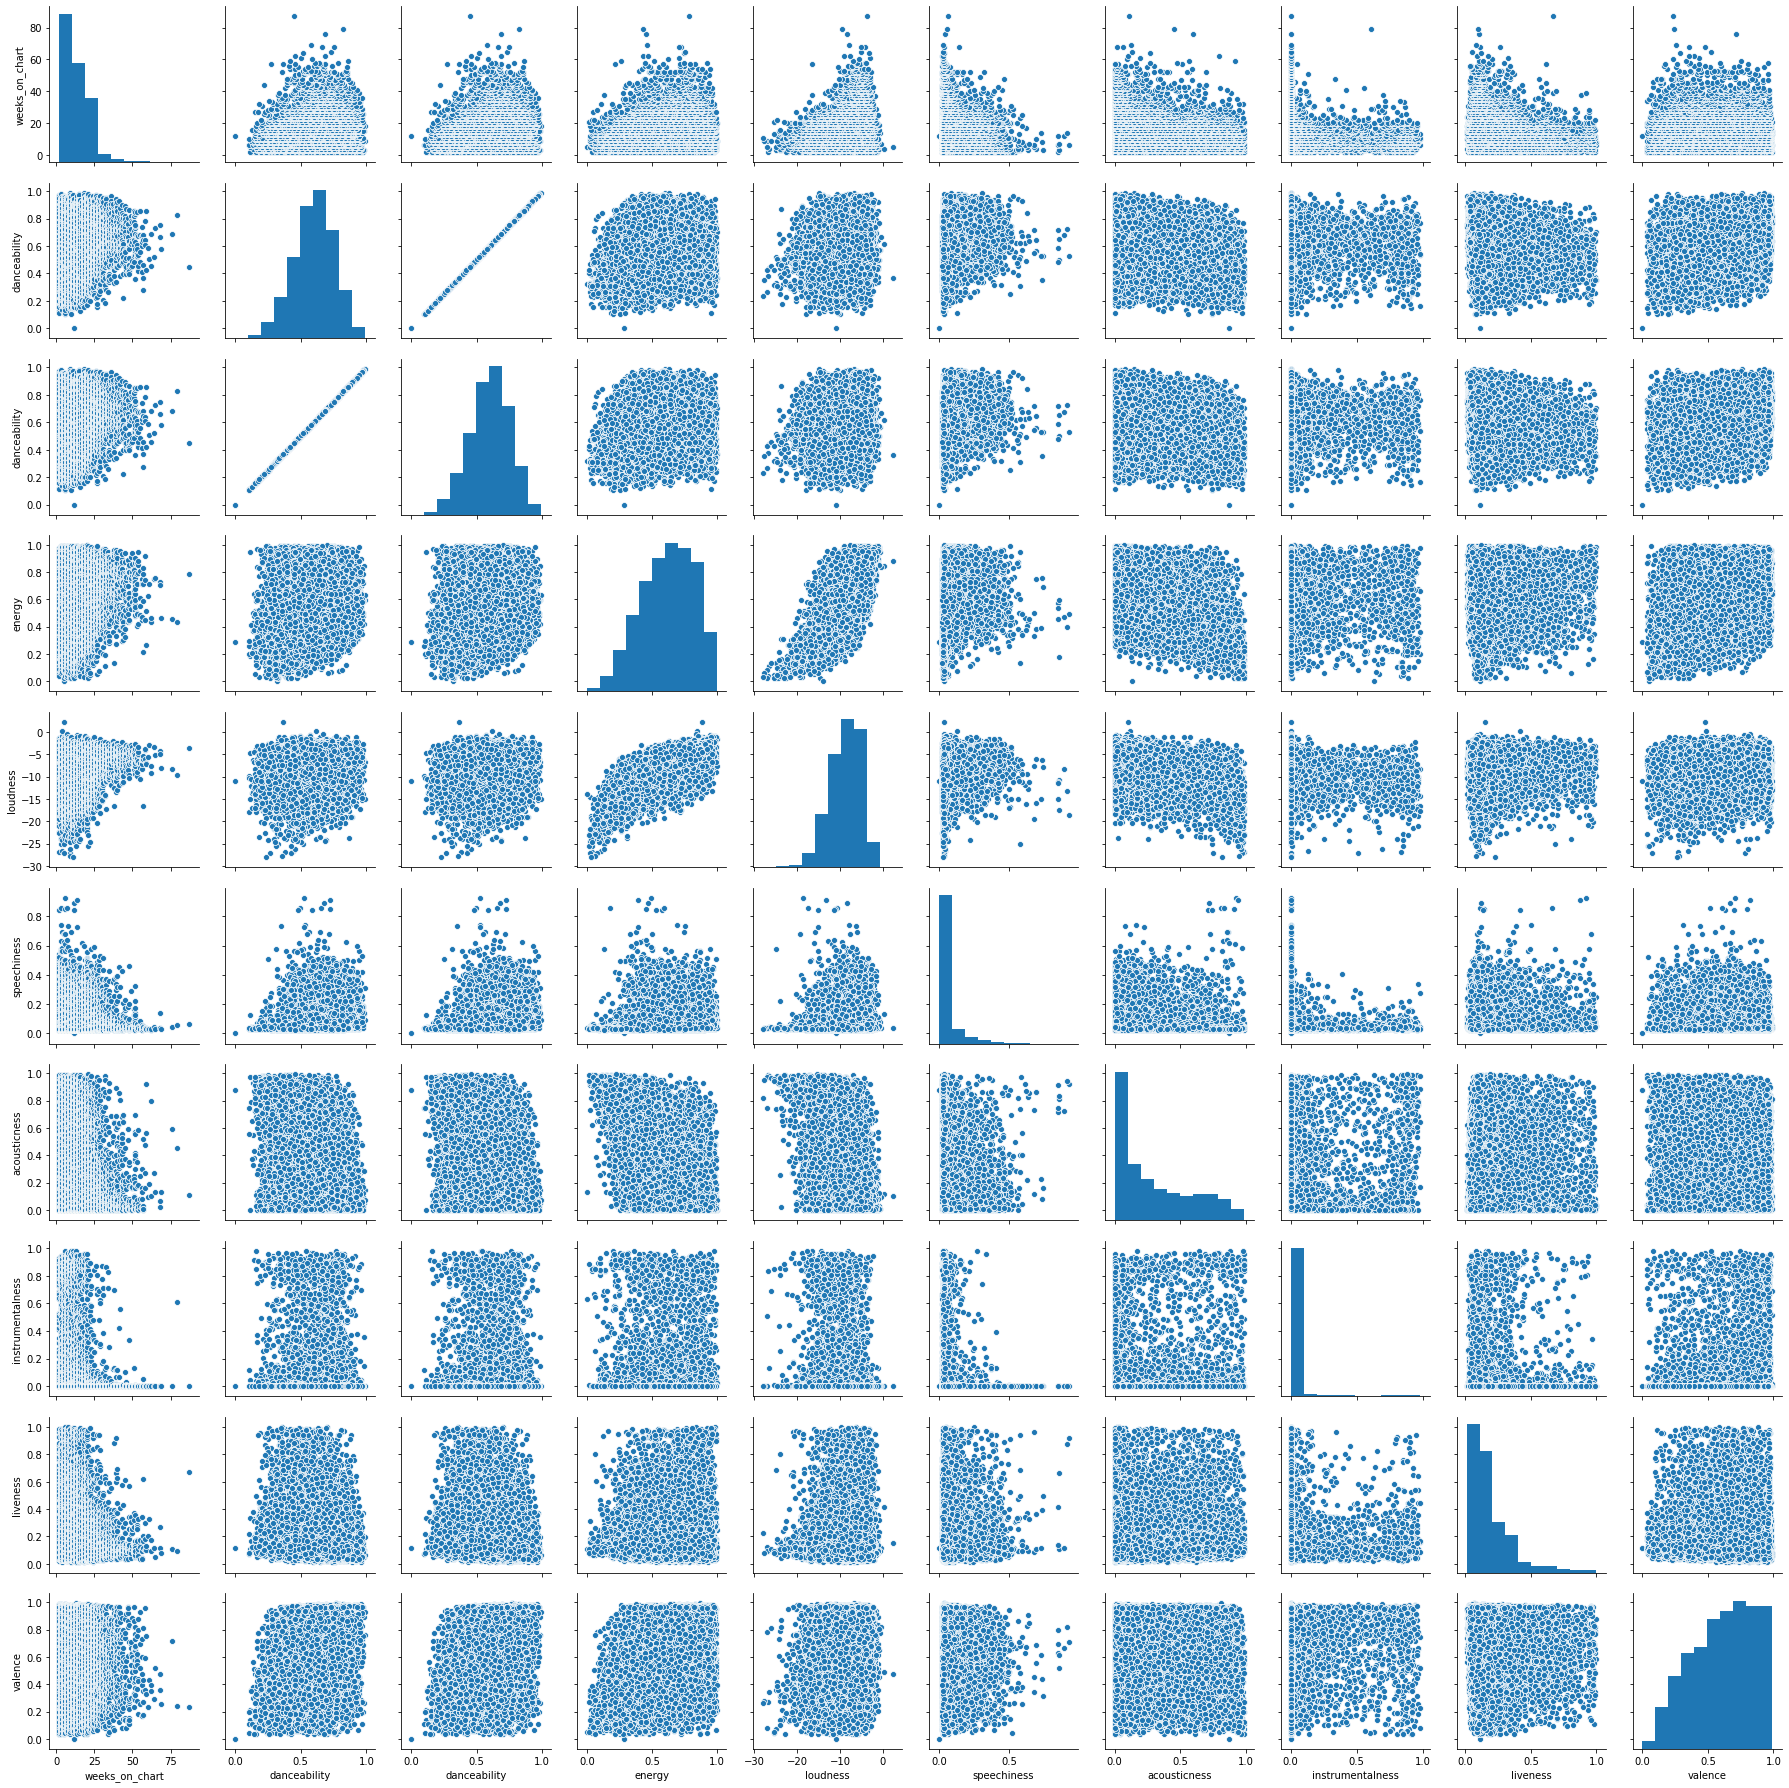

In [200]:
sns.pairplot(peak_df, vars=['weeks_on_chart','danceability', 'danceability', 'energy',
                      'loudness', 'speechiness', 'acousticness', 
                      'instrumentalness', 'liveness', 'valence']);

In [20]:
X = df.drop(['weekid', 'week_position', 'song', 'performer', 'songid',
            'instance', 'previous_week_position', 'peak_position',
            'weeks_on_chart', 'spotify_track_popularity'], axis = 1)

In [21]:
X['key'] = X['key'].astype(str)

In [22]:
X = pd.get_dummies(X, drop_first=True)

In [23]:
# For later
spot_features = X.drop(['adultstandards', 'albumrock', 'brillbuildingpop', 'bubblegumpop',
                        'classicrock', 'contemporarycountry', 'country', 'countryroad',
                        'dancepop', 'disco', 'folkrock', 'funk', 'hiphop', 'hippop', 'mellowgold',
                        'motown', 'newwavepop', 'pop', 'poprap', 'poprock', 'post', 'quietstorm',
                        'rap', 'rock', 'softrock', 'soul', 'urbancontemporary', 'other'],
                       axis=1).columns

In [194]:
y = df['weeks_on_chart']

In [210]:
from sklearn.preprocessing import PowerTransformer

In [ ]:
trans = PowerTransformer()
trans.fit_transform([y]).hist()

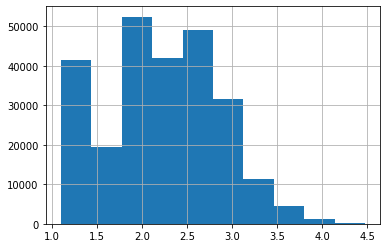

In [209]:
np.log1p(y).hist();

In [195]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, shuffle = True)

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [180]:
from sklearn.linear_model import ElasticNetCV

In [196]:
enet = ElasticNetCV(l1_ratio=np.linspace(0,1,20), alphas=np.logspace(-4,4,20)).fit(X_train, y_train)

In [197]:
cross_val_score(enet, cv=5, X=X_train, y=y_train, n_jobs=2)

array([0.10621471, 0.10793082, 0.10757683, 0.11174149, 0.10447101])

In [179]:
param_grid = {
    
    'n_estimators':[150],
    'max_depth':[5],
    
}

grid = GridSearchCV(RandomForestRegressor(random_state = 1),
                    param_grid,
                    cv = 5,
                    verbose = 2,
                    n_jobs = 2).fit(X_train, y_train)

print(grid.best_score_)

print(grid.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.9min remaining:    0.0s
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  4.9min finished


0.12268865417932
{'max_depth': 5, 'n_estimators': 150}


---

# Time Series Modelling

Time series problems contain many challenges and questions to ask. As referenced in Deep Learning for Time Series by Jason Brownlee, there are 7 major considerations that we will look at:
- **Endogenous vs. Exogenous:** which variables are effected by those in the system (endo) which are outside/indirectly affected (exo)?
- **Unstructured vs. Structured:** seasonality or other features that render the time series strucured or structureless?
- **Regression vs. Classification:** are we looking for up/down or how much does it go up?
- **Univariate vs. Multivariate:** are we looking at a model that works with just autocorrelations or variables that impact a trend?
- **Single step vs. Multi step:** one step into the future or a long term prediction?
- **Static vs. Dynamic:** do we want to be able to update the model as we go along or is it fixed in time?
- **Contiguous vs. Discontiguous:** is the time series full (all data evenly spaced) or are there gaps?

### This section will look at various ways we can approach making predictions about the future or music.

There are many things we can look at with the data that we have.
1. Subset by genre (percentage of songs in the charts that are of a certain genre) and try to look at their trends to predict whether the genre will grow
2. Look at certain spotify features (underlying musical features) to see if there are trends in certain types of music in the charts
3. 

In [24]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from arch import arch_model

In [25]:
def convert_to_dt_indexed(df):
    return df.set_index(pd.to_datetime(df['weekid'])).drop('weekid', axis = 1)

In [26]:
time_df = convert_to_dt_indexed(df)

In [77]:
time_df.columns

Index(['week_position', 'song', 'performer', 'songid', 'instance',
       'previous_week_position', 'peak_position', 'weeks_on_chart',
       'spotify_track_duration_ms', 'spotify_track_popularity', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'adultstandards', 'albumrock', 'brillbuildingpop', 'bubblegumpop',
       'classicrock', 'contemporarycountry', 'country', 'countryroad',
       'dancepop', 'disco', 'folkrock', 'funk', 'hiphop', 'hippop',
       'mellowgold', 'motown', 'newwavepop', 'pop', 'poprap', 'poprock',
       'post', 'quietstorm', 'rap', 'rock', 'softrock', 'soul',
       'urbancontemporary', 'other'],
      dtype='object')

In [202]:
ncols = 3
nrows = 14
index_pos = []
for i in range(ncols):
    for j in range(nrows):
        index_pos.append([j,i])

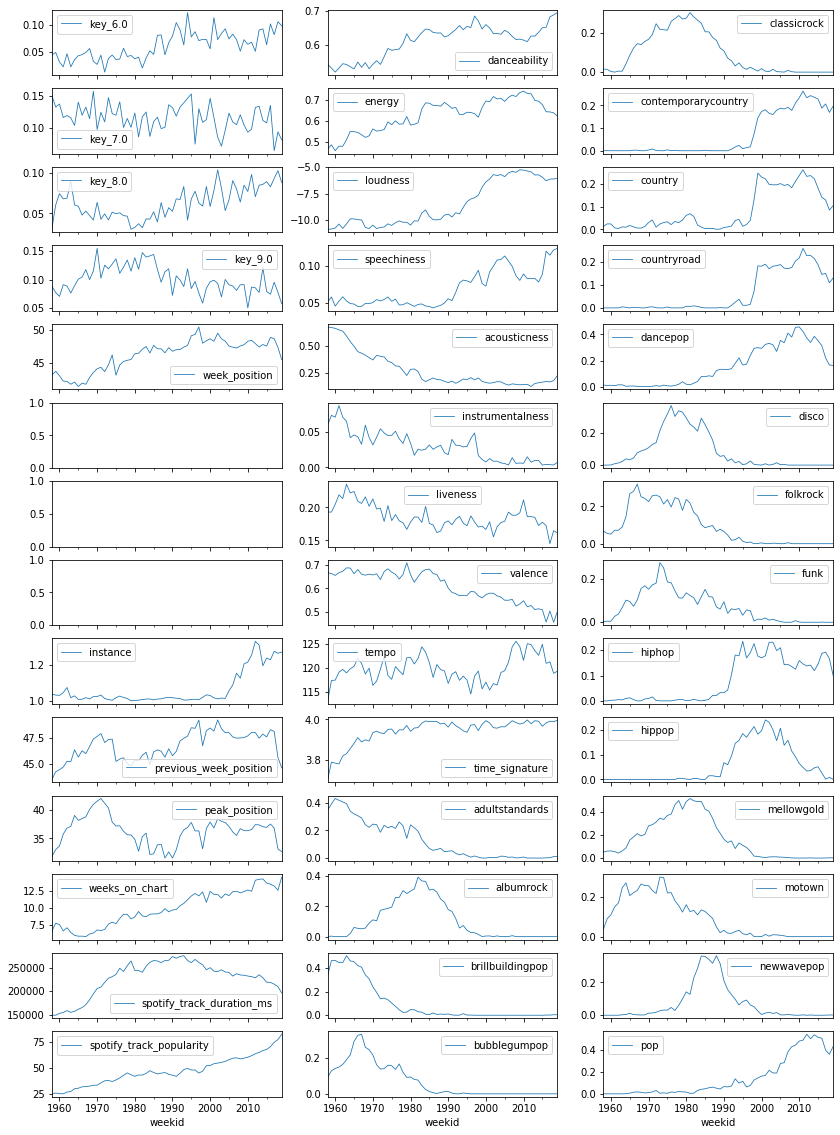

In [207]:
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(14,20), sharex = True)
for i, v in enumerate(time_df.iloc[:,8:].columns):
    try:
        time_df[[v]].resample('y').mean().plot(ax = axs[tuple(index_pos[i])], lw=0.8);
    except:
        pass

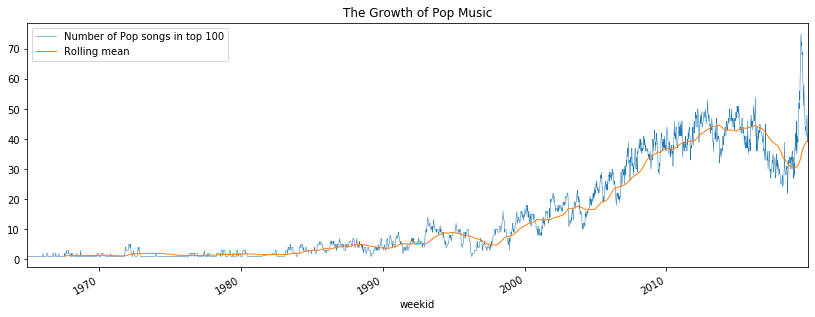

In [58]:
fig, ax = plt.subplots(figsize = (14,5))
time_df[time_df['pop']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.5, ax=ax);
time_df[time_df['pop']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Number of Pop songs in top 100', 'Rolling mean'])
ax.set_title('The Growth of Pop Music');


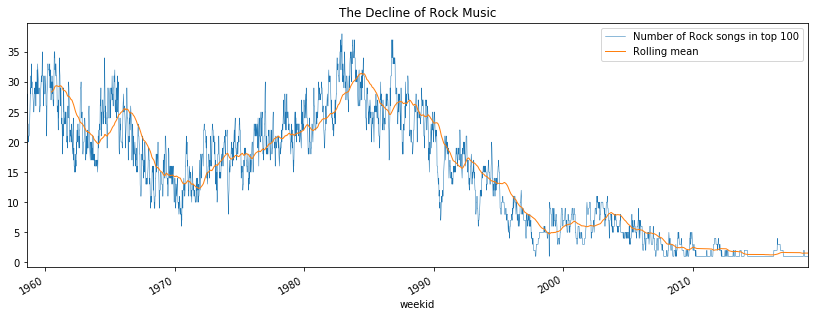

In [68]:
fig, ax = plt.subplots(figsize = (14,5))
time_df[time_df['rock']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.5, ax=ax);
time_df[time_df['rock']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Number of Rock songs in top 100', 'Rolling mean'])
ax.set_title('The Decline of Rock Music');


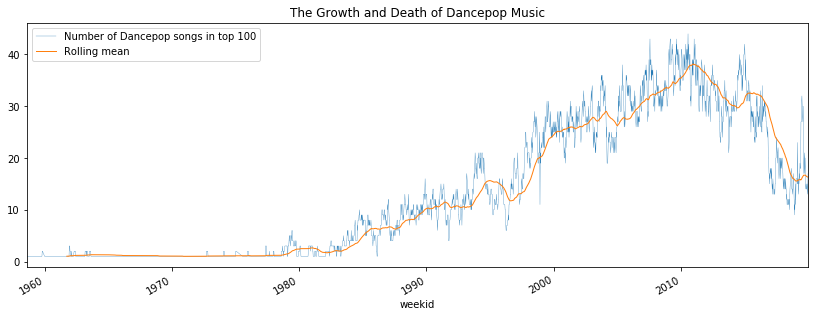

In [69]:
fig, ax = plt.subplots(figsize = (14,5))
time_df[time_df['dancepop']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df[time_df['dancepop']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Number of Dancepop songs in top 100', 'Rolling mean'])
ax.set_title('The Growth and Death of Dancepop Music');


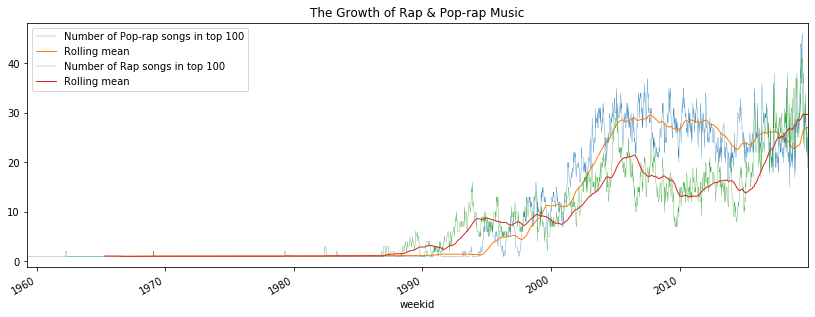

In [82]:
fig, ax = plt.subplots(figsize = (14,5))
time_df[time_df['poprap']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df[time_df['poprap']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
time_df[time_df['rap']==1].groupby('weekid')[['week_position']].count().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df[time_df['rap']==1].groupby('weekid')[['week_position']].count().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Number of Pop-rap songs in top 100', 'Rolling mean', 'Number of Rap songs in top 100', 'Rolling mean'])
ax.set_title('The Growth of Rap & Pop-rap Music');

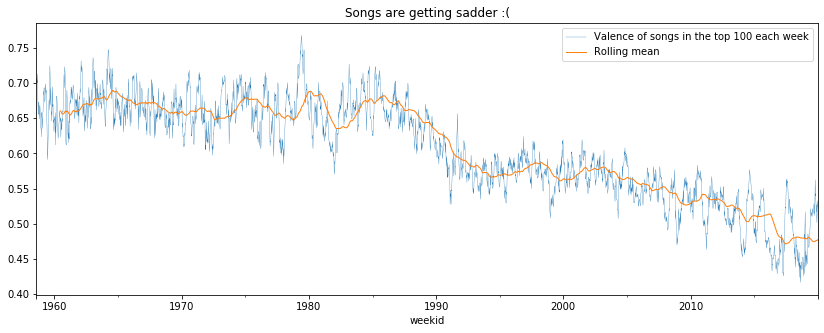

In [71]:
fig, ax = plt.subplots(figsize = (14,5))
time_df.groupby('weekid')[['valence']].mean().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df.groupby('weekid')[['valence']].mean().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Valence of songs in the top 100 each week', 'Rolling mean'])
ax.set_title('Songs are getting sadder :(');

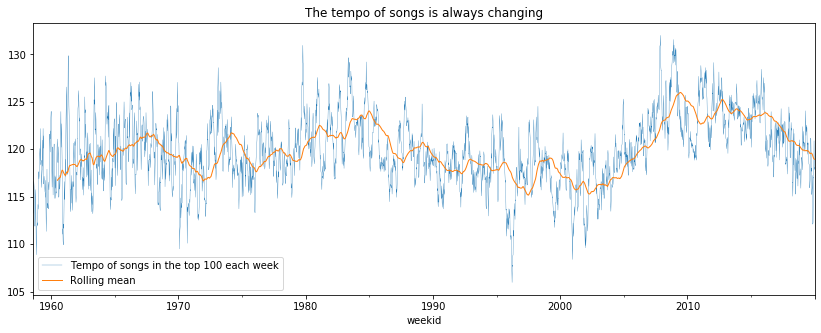

In [72]:
fig, ax = plt.subplots(figsize = (14,5))
time_df.groupby('weekid')[['tempo']].mean().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df.groupby('weekid')[['tempo']].mean().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Tempo of songs in the top 100 each week', 'Rolling mean'])
ax.set_title('The tempo of songs is always changing');

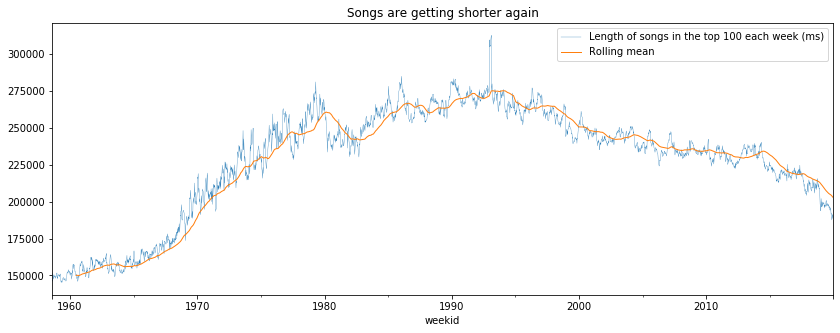

In [80]:
fig, ax = plt.subplots(figsize = (14,5))
time_df.groupby('weekid')[['spotify_track_duration_ms']].mean().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df.groupby('weekid')[['spotify_track_duration_ms']].mean().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Length of songs in the top 100 each week (ms)', 'Rolling mean'])
ax.set_title('Songs are getting shorter again');

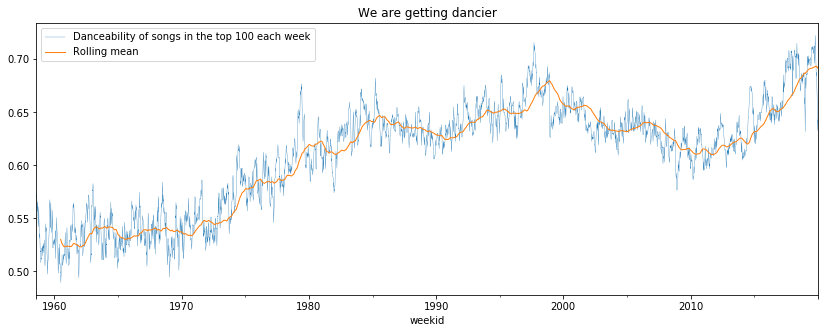

In [84]:
fig, ax = plt.subplots(figsize = (14,5))
time_df.groupby('weekid')[['danceability']].mean().rolling(window=1).mean().plot(lw=0.3, ax=ax);
time_df.groupby('weekid')[['danceability']].mean().rolling(window=100).mean().plot(lw=1, ax=ax);
plt.legend(['Danceability of songs in the top 100 each week', 'Rolling mean'])
ax.set_title('We are getting dancier');

# Forecasting

There are many models we can look at.
Some options:
- Observing the movement of the top song on billboard given some features.
- Percentage of a given genre in top 100

In [27]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [28]:
time_df['key'] = time_df['key'].astype(str)
time_df = pd.concat([(pd.get_dummies(time_df[['mode', 'key']], drop_first=True)),
                     time_df.drop(['mode', 'key'], axis=1)],
                    axis=1)


### Model 1: Predicting pop with autocorrelations

We will look for the percentage of top100 songs on a given week being a pop song.

In [29]:
pop_trends = time_df[['pop']].groupby('weekid').mean()

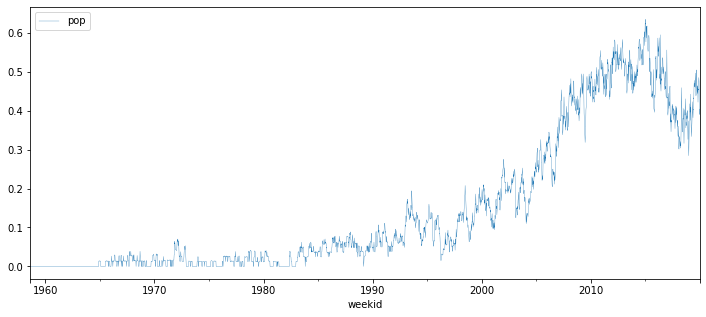

In [94]:
fig, ax = plt.subplots(figsize=(12,5))
pop_trends.plot(lw=0.3, ax=ax);

The above plot doesn't show stationarity (the mean and covariance shouldnt be a function of time) - we will need to subset the data to fulfil this criteria.

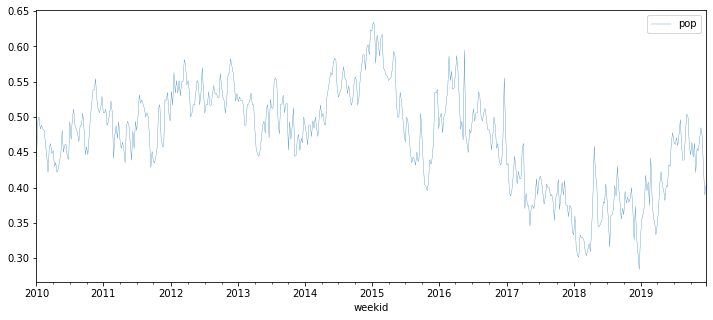

In [31]:
year = 2010
fig, ax = plt.subplots(figsize=(12,5))
pop_trends[pop_trends.index>'{}-01-01'.format(year)].plot(lw=0.3, ax=ax);

That looks better, we will no subset with this criteria - post 2008 tracks.

In [98]:
year = 2014
pop_trends = pop_trends[pop_trends.index>'{}-01-01'.format(year)]

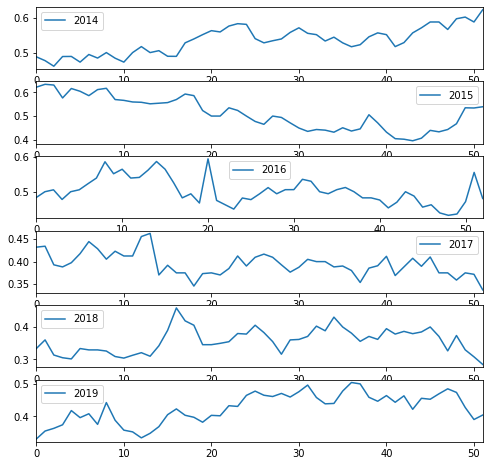

In [111]:
years = list(pop_trends.index.year.unique())
fig, ax = plt.subplots(figsize=(8,8), nrows=len(years))
for i,y in enumerate(years):
    temp_pop_df = pop_trends[pop_trends.index.year==y]
    temp_length = temp_pop_df.shape[0]
    temp_pop_df.index = [i for i in range(temp_length)]
    temp_pop_df.columns = [y]
    temp_pop_df.plot(ax=ax[i])
    
plt.show()

There doesn't appear to be much seasonality in pop listening.  

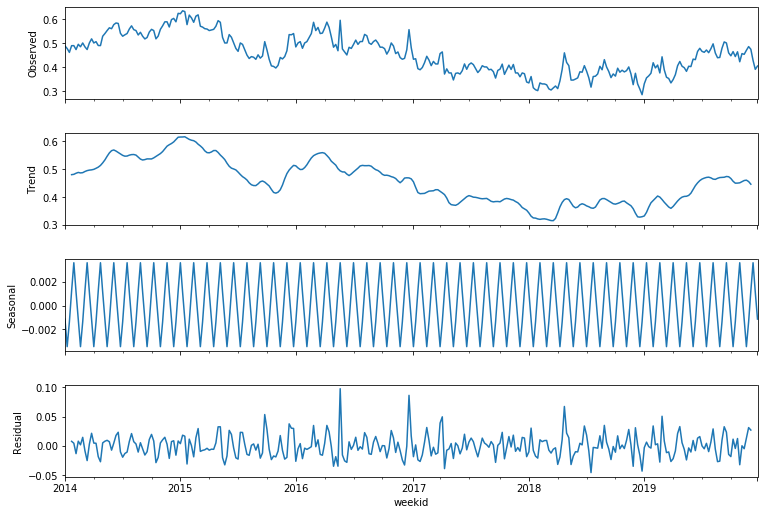

In [104]:
period = len(years)
decomposition = seasonal_decompose(pop_trends, freq=period)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

We shouldn't really expect any repeating trend for the number of pop songs in the top 100. There may be an effect that at Christmas time, there are an increased number of pop songs but even this is spurious.

### Baseline/Naive Models

Given what we've explored above, we would expect that our most sensible estimate for future observations would be based on the most recent data. Tomorrow will most likely be the same as yesterday (as opposed to using the same week last year/month etc.)

In [47]:
from math import sqrt
from numpy import mean
from numpy import median
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error

In [69]:
def simple_forecast(history, config): 
    n, offset, avg_type = config
    if avg_type == 'persist':
        return history[-n]
    values = list()
    if offset == 1:
        values = history[-n:]
    else:
        if n*offset > len(history):
            raise Exception('Config beyond end of data: %d %d' % (n,offset))
        for i in range(1, n+1):
            ix = i * offset
            values.append(history[-ix])
    if len(values) < 2:
        raise Exception('Cannot calculate average')
    if avg_type == 'mean': 
        return mean(values)
    return median(values)

def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]                                                                                                    

def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = simple_forecast(history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = measure_rmse(test, predictions)
    return error

def score_model(data, n_test, cfg):
    result = None
    key = str(cfg)
    try:
        with catch_warnings():
            filterwarnings("ignore")
            result = walk_forward_validation(data, n_test, cfg)
    except:
        error = None
    return (key, result)

def grid_search(data, cfg_list, n_test, parallel=True):
    scores = None
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    scores = [r for r in scores if r[1] != None]
    scores.sort(key=lambda tup: tup[1])
    return scores

def simple_configs(max_length, offsets=[1]):
    configs = list()
    for i in range(1, max_length+1):
        for o in offsets:
            for t in ['persist', 'mean', 'median']:
                cfg = [i, o, t]
                configs.append(cfg)
    return configs

In [81]:
year = 2014
data = pop_trends[pop_trends.index>'{}-01-01'.format(year)]['pop']

test_split = 0.2
n_test = int(len(data)*test_split)

max_length = len(data) - n_test
cfg_list = simple_configs(max_length)

scores = grid_search(data, cfg_list, n_test)

for cfg, error in scores[:5]:
    print(cfg, error)

done
[1, 1, 'persist'] 0.026903968198236174
[2, 1, 'mean'] 0.028527574220946872
[2, 1, 'median'] 0.028527574220946872
[3, 1, 'mean'] 0.03116333052937008
[3, 1, 'median'] 0.03154692835473563


Our error here is minimised when we just take the most recent value as our prediction and this returns an error of 2.6%. We can also return an error of just 2.8% through using the mean of the past two values.

## Predictive Modelling

We will use walk-forward validation wherein we predict week 2 on week 1, week 3 on weeks 1 and 2, week 4 on weeks 1,2 and 3 etc.

## ARIMA models

In [97]:
# Please note that this function is an adaptation from blackarbs.com - credit to them!
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

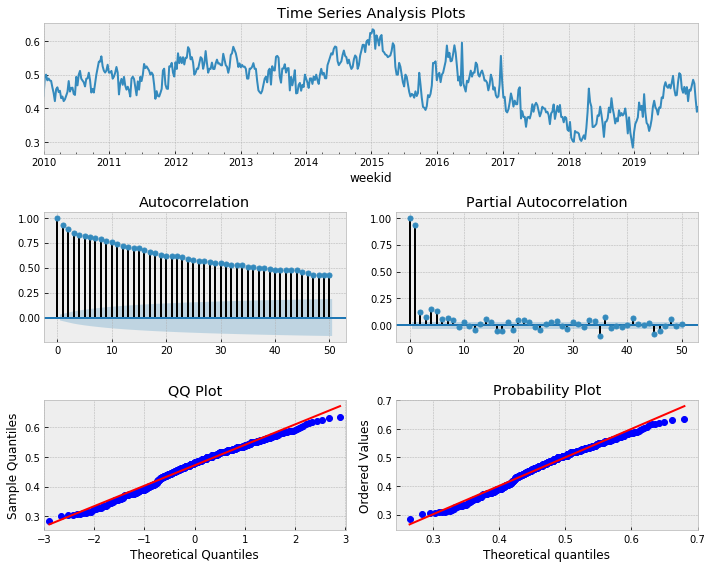

In [98]:
tsplot(pop_trends['pop'], lags=50)

We can see that our data is non stationary. Our autocorrelation plot shows a gradual decrease where we would want to see a sharp drop-off after the first or second lag.

We can use differencing to eliminate this effect. Here we simply minus each point by the one previous to it.

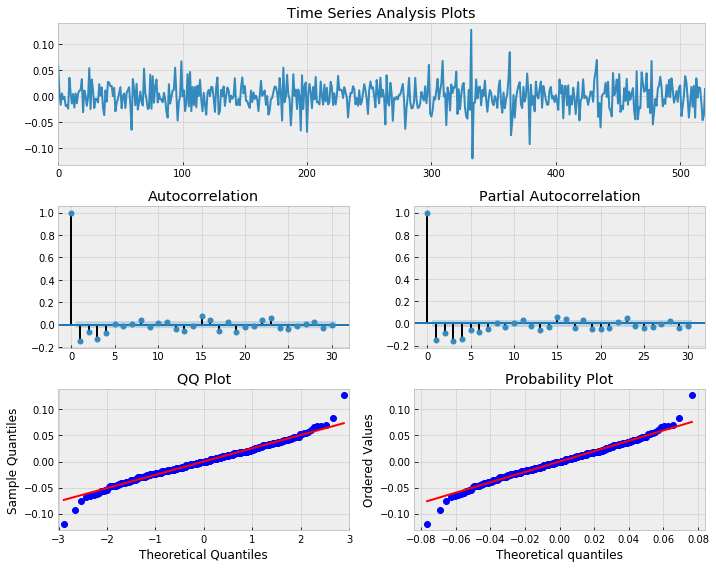

In [99]:
tsplot(np.diff(pop_trends['pop'], n=1), lags=30)

We see better autocorrelations here but still some concern. Also the edge values in the QQ plots suggest there are still some serial correlations - this may be down to the values at lags 1,2,3,4,6 and 15.

We will search through different values of p, d and q to identify the optimal difference value and autoregressive and moving average coeffs. The autoregressive feature will allow us to handle momentum and the moving average will handle sudden spikes.

aic: -2385.99701 | order: (4, 0, 1)


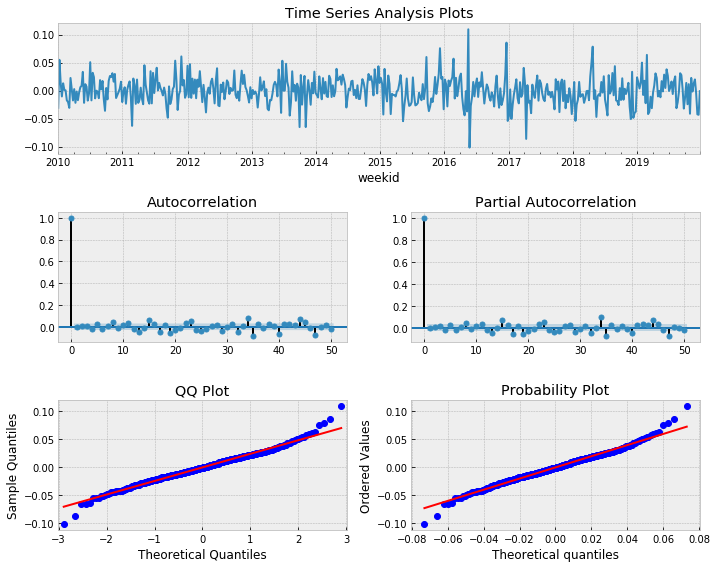

In [118]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5)
d_rng = range(2) 
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(pop_trends['pop'], order=(i,d,j)).fit(method='mle', trend='c')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

tsplot(best_mdl.resid, lags=50)

Our ACF and PACF plots only really show deviation at week-lags 35, 35 and 47 but otherwise look okay. These probably link to the edge values in the QQ plot.

In [140]:
# Create a 52 week forecast of pop popularity with 95%, 99% CI
n_steps = 52

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(pop_trends['pop'].index[-1], periods=n_steps, freq='W')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head(10)

forecast  lower_ci_95  lower_ci_99  upper_ci_95  upper_ci_99
2019-12-29  0.417335     0.369833     0.354907     0.464836     0.479763
2020-01-05  0.428157     0.368071     0.349190     0.488243     0.507123
2020-01-12  0.431821     0.364278     0.343055     0.499363     0.520587
2020-01-19  0.432247     0.361060     0.338691     0.503435     0.525804
2020-01-26  0.431586     0.357725     0.334516     0.505448     0.528657
2020-02-02  0.431294     0.355037     0.331075     0.507552     0.531513
2020-02-09  0.431557     0.352872     0.328147     0.510241     0.534966
2020-02-16  0.432188     0.351079     0.325593     0.513298     0.538784
2020-02-23  0.432932     0.349476     0.323252     0.516388     0.542612
2020-03-01  0.433650     0.347979     0.321060     0.519320     0.546240

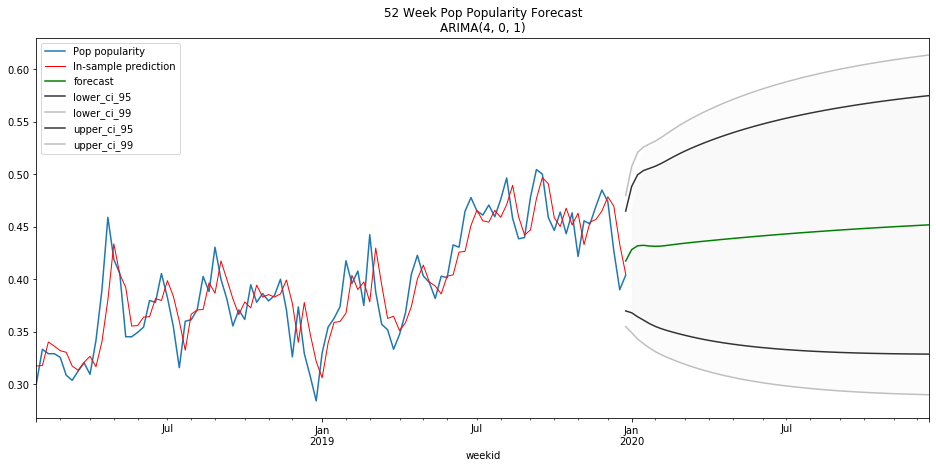

In [153]:
fig = plt.figure(figsize=(16,7))
ax = plt.gca()

ts = pop_trends['pop'].iloc[-100:].copy()
ts.plot(ax=ax, label='Pop popularity')

pred = (best_mdl.predict(ts.index[0], ts.index[-1]))
pred.plot(ax=ax, style='r-', label='In-sample prediction', lw=1)

styles = ['g-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.02)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.02)
plt.title('{} Week Pop Popularity Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10);

## Exponential Smoothing

We adjust the value of alpha to control smoothing - 0 gives equal waiting to all past observations, 1 gives full value to the most recent observation (naive method).

In [1]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

## Analysis

The above model is univariate and so we may not need a much more complex mode of modelling than using ARIMA. We can consider using GARCH to adjust for volatility.

We can introduce complexity to enrich the forecast. We will add in the median values of the various sonic features that the group of pop songs possess.

Typically, its in this domain where machine learning becomes relevant. It doesn't always outperform traditional time series modelling techniques on univariate time series' but when we increase complexity, machine learning will start to offer use significant value.

We will be working with the below features.

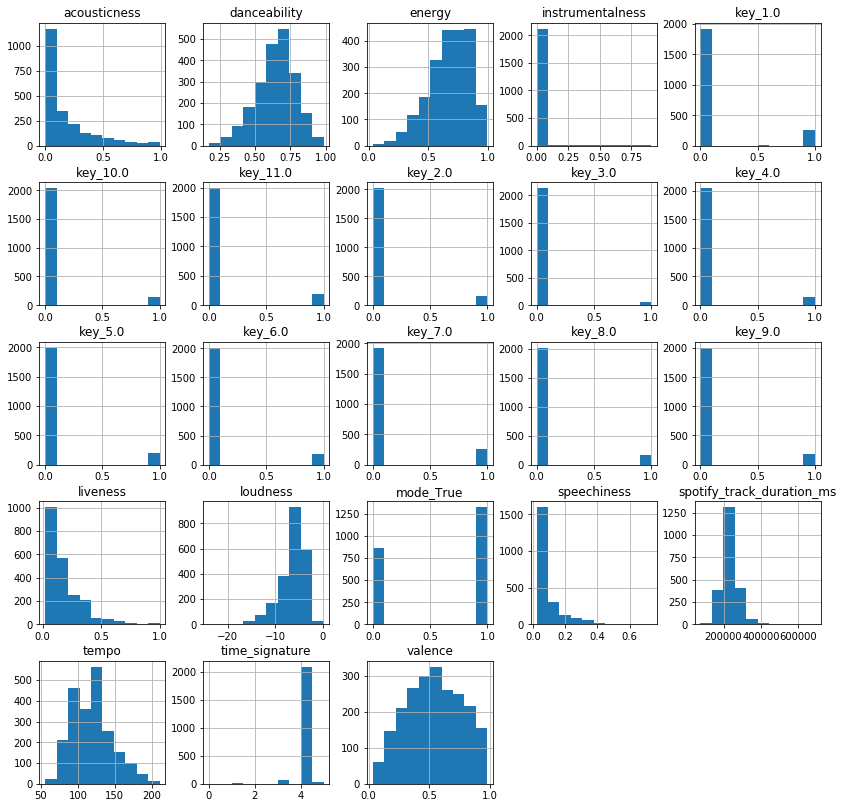

In [234]:
fig, ax = plt.subplots(figsize=(14,14))
time_df[(time_df['pop']==1)].groupby('song').median()[spot_features].hist(ax=ax);

In [244]:
pop_spot_features = time_df[time_df['pop']==1].groupby('weekid').mean()[spot_features]

In [256]:
pop_spot_features= pd.DataFrame(StandardScaler().fit_transform(pop_spot_features),
                     columns=pop_spot_features.columns,
                     index=pop_spot_features.index)

In [257]:
pop_data = pd.merge(time_df[['pop']].groupby('weekid').mean(), pop_spot_features, left_index=True, right_index=True)

In [299]:
pop_data.to_csv('pop_data.csv')

### Model 2: Bringing in features

In [110]:
top_spot = time_df[[*list(spot_features), 'pop']]

In [108]:
top_spot.sort_values(by='weekid', inplace=True)

In [109]:
tt_split = 0.8
train = top_spot.head(int(tt_split*len(top_spot)))
test = top_spot.tail(len(top_spot)-int(tt_split*len(top_spot)))

In [102]:
from sklearn.model_selection import TimeSeriesSplit
ts = TimeSeriesSplit()
splits = [split for split in ts.split(train)]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
ts = TimeSeriesSplit()
TimeSeriesSplit(max_train_size=None, n_splits=5)
for train_index, test_index in tscv.split(X):
     print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


In [ ]:
def evaluate_forecasts(actual, predicted):
    scores = list()
    for i in range(actual.shape[1]):
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        rmse = sqrt(mse)
        scores.append(rmse)
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

## Data prep practice

In [295]:

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
    # find the end of this pattern
        end_ix = i + n_steps
    # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
    # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [292]:
temp_data = list(pop_data['pop'].head(20).values)

In [296]:
split_sequence(temp_data, 3)

(array([[0.01388889, 0.01388889, 0.01351351],
        [0.01388889, 0.01351351, 0.01470588],
        [0.01351351, 0.01470588, 0.01408451],
        [0.01470588, 0.01408451, 0.01333333],
        [0.01408451, 0.01333333, 0.01408451],
        [0.01333333, 0.01408451, 0.01333333],
        [0.01408451, 0.01333333, 0.01351351],
        [0.01333333, 0.01351351, 0.01369863],
        [0.01351351, 0.01369863, 0.01333333],
        [0.01369863, 0.01333333, 0.01388889],
        [0.01333333, 0.01388889, 0.01388889],
        [0.01388889, 0.01388889, 0.01492537],
        [0.01388889, 0.01492537, 0.01449275],
        [0.01492537, 0.01449275, 0.01315789],
        [0.01449275, 0.01315789, 0.01298701],
        [0.01315789, 0.01298701, 0.0125    ],
        [0.01298701, 0.0125    , 0.01333333]]),
 array([0.01470588, 0.01408451, 0.01333333, 0.01408451, 0.01333333,
        0.01351351, 0.01369863, 0.01333333, 0.01388889, 0.01388889,
        0.01492537, 0.01449275, 0.01315789, 0.01298701, 0.0125    ,
        0.01